# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Han Li

**Student ID:**  32710542

## Part 1:  Text Classification

General comments and any shared processing here.

## Set up
##### Below block is for loading all libraries required for the project and preliminary set up including device and seed


In [1]:
#For data loading and manipulation
import numpy as np
import pandas as pd

#For data visulisation
%matplotlib inline
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
import plotly as py

#For preprocssing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk import PorterStemmer,WordNetLemmatizer,wordpunct_tokenize,word_tokenize
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

#For Modelling
#pip install xgboost
#pip install lightgbm
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F


#For performance metrics, data spliting
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay,
                             precision_score,accuracy_score,
                             recall_score,matthews_corrcoef,precision_recall_curve)

#For Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Utilities
import warnings
warnings.filterwarnings('ignore')
import random
import os
import re

This task is to train a statistic NLP model for classify artical class by either Abstract or Titles. To do so I will be applying 2 different preprocessing configuration

In [2]:
# Seed for reprodiction
SEED = 23
def seeding(SEED = SEED):
    """SEED: int number define by variable SEED"""
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)
seeding() 

# Setting up cuda for Colab GPU runtime and mps for ARM enviroment
# The code will be test under macos arm with mps support and Colab GPU runtime with cuda support
device = torch.device('cuda' if 
torch.cuda.is_available() else 'mps')

### Data Loading

In [3]:
#Assert train.csv and test.csv are in working directory
train_dir = (os.getcwd() +'/train.csv' if 'train.csv' in os.listdir() else print('training set not in working directory'))
test_dir = (os.getcwd() +'/test.csv' if 'test.csv' in os.listdir() else print('testing set not in working directory'))

#Load datasets
df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)

In [4]:
#Inspect train and test data
df_train.sample(10)
df_test.sample(5)

,title,abstract,InformationTheory,ComputationalLinguistics,ComputerVision
17289,GRADE-AO: Towards Near-Optimal Spatially-Coupl...,Spatially-coupled (SC) codes known for their...,1,0,0
14713,Neural Fields as Learnable Kernels for 3D Reco...,We present Neural Kernel Fields: a novel met...,0,0,1
3532,Investigations on $c$-Boomerang Uniformity and...,We defined in~citeEFRST20 a new multiplicati...,1,0,0
17692,Linear Adversarial Concept Erasure,Modern neural models trained on textual data...,0,1,0
9882,Parsing Free Word-Order Languages in Polynomia...,We present a parsing algorithm with polynomi...,0,1,0


In [5]:
# Function that perform train_validation split in 2 size,the random 1000 sample and full dataset
def df_train_val_split(df ,task,input,size):
    """
    df:dataset to be split in to training and validation sets

    task:Dependent variables can be choose from ['InformationTheory','ComputationalLinguistics','ComputerVision']
    
    input:independent variable that can be choose from ['title','abstract']

    size = select from ['full','sample'] to return either 10% or entire training set

    df_train_1k, df_val_1k: The first 1000 sample of the df_train set(900 inputs), and split 10% as validation set(100 inputs)

    df_train_all, df_val_all: The entire training data(112500 inputs) excluding 10% as validation set(12500 inputs)

    Return: X_train,X_val,y_train,y_val the training and validation value as list for both X and y variables
    """
    #Assert inputs meets function requirement
    assert input in ['title','abstract'],'Please ensure input is choosen from title and abstract'
    assert task in ['InformationTheory','ComputationalLinguistics','ComputerVision'],'Please ensure column name you wish to predict are correct'
    assert size in ['full','sample'], 'choose only full or sample dataset'
    
    if size =='sample':
        df_train_1k = df.sample(1000).reset_index(drop = True)
        df_train_1k,df_val_1k = train_test_split(df_train_1k,test_size=.1)
        X_train = df_train_1k[input].tolist()
        X_val = df_val_1k[input].tolist()
        y_train = df_train_1k[task].tolist()
        y_val = df_val_1k[task].tolist()

    elif size =='full':
        df_train_all,df_val_all = train_test_split(df_train,test_size=.1)
        X_train = df_train_all[input].tolist()
        X_val = df_val_all[input].tolist()
        y_train = df_train_all[task].tolist()
        y_val = df_val_all[task].tolist()

    return X_train,X_val,y_train,y_val

### Preprocessing


#### This project will adapt 2 method in preprocessing
##### 1. with stopword,multi spaces,special charters,symbols removeal,re-shuffle df order and use potter stemmer for corpos normalization

##### 2.  with special charters,symbols removeal and use Lemmalization for corpos normalization


##### all method will be wrapped into single function

In [6]:
class TextPreprocessor(object):
    def __init__(self, method=1, max_features=400):
        self.method = method
        self.max_features = max_features
        self.stopwords = set(stopwords.words('english'))

        if method == 1:
            self.tokenizer = PorterStemmer()
            self.vectorizer = TfidfVectorizer(max_features=max_features, tokenizer=self.tokenize)
        else:
            self.tokenizer = WordNetLemmatizer()
            self.vectorizer = CountVectorizer(max_features=max_features, tokenizer=self.tokenize)

    def tokenize(self, doc):
        return [self.tokenizer.lemmatize(t) if self.method == 2 else self.tokenizer.stem(t) for t in word_tokenize(doc)]

    def preprocess(self, text):
        """
        text :raw text from dataset input
        Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
        Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer
        """
        text = text.lower()
        text = re.sub(r'\n', '', text)
        text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text)
        text = re.sub(' +', ' ', text)
        text = text.strip()

        if self.method == 1:
            pattern = re.compile(r'\b(' + r'|'.join(self.stopwords) + r')\b\s*')
            text = pattern.sub('', text)
            text = re.sub(r'\([^)]*\)', '', text)

        return text

    def fit_transform(self, texts):
        preprocessed_texts = [self.preprocess(text) for text in texts]
        return self.vectorizer.fit_transform(preprocessed_texts)


In [7]:
# Supporting lemmatizer and tokenizer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


class SteamTokenizer(object):
    def __init__(self):
        self.ps = PorterStemmer()

    def __call__(self, doc):
        return [self.ps.stem(t) for t in word_tokenize(doc)]


stem_vectorizer = TfidfVectorizer(max_features=400,
                                  tokenizer=SteamTokenizer())

lemma_vectorizer = CountVectorizer(
    tokenizer=LemmaTokenizer(),
    max_features=400
)

def preprocess(text,method = 1):
    """
    text :raw text from dataset input
    method: int 1 or 2, refer to differetn preprocessing method
    Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
    Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer
    """
    assert method in [1,2],'Please select 1 or 2 only'
    STOPWORDS = set(stopwords.words('english'))

    # Lower
    text = text.lower()
    # Remove Special characters
    text = re.sub(r'\n','',text)
    # Spacing and filters
    text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
    text = re.sub(' +', ' ', text)  # remove multiple spaces
    text = text.strip() 

    if method == 1:
        # Remove stopwords
        pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
        text = pattern.sub('', text)
        # Remove words in paranthesis
        text = re.sub(r'\([^)]*\)', '', text)

    else:
        pass

    return text

In [8]:
class text_preprocessing(object):
    def __init__(self):
        self.object = object
    def Dataloading(df,task,input,size):
        return df_train_val_split(df,task,input,size)
    def clean(X_train,X_val,y_train,y_val,method):
        if method == 1:
            X_train = [preprocess(i,method =1 ) for i in X_train]
            X_train = stem_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [preprocess(i,method =1 ) for i in X_val]
            X_val = stem_vectorizer.fit_transform(X_val).astype(np.float64)
        elif method == 2:
            X_train = [preprocess(i,method =2 ) for i in X_train]
            X_train = lemma_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [preprocess(i,method =2 ) for i in X_val]
            X_val = lemma_vectorizer.fit_transform(X_val).astype(np.float64)
        y_train = np.asarray(y_train)
        y_val =np.asanyarray(y_val)
        return X_train,X_val,y_train,y_val

In [9]:
#perform data splitting and preprocessing
X_train,X_val,y_train,y_val = text_preprocessing.Dataloading(df_train,task = 'ComputerVision',input = 'abstract',size = 'sample')
X_train,X_val,y_train,y_val = text_preprocessing.clean(X_train,X_val,y_train,y_val,method = 1)

In [10]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

X_train shape: (900, 400)
X_val shape: (100, 400)


In [11]:
models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier(),
    'BaggingClassifier': BaggingClassifier(),
    'CatBoostClassifier': CatBoostClassifier(metric_period=600)
}
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model_name, model in models.items():
     accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
best_model_name = cv_df.groupby('model_name')['accuracy'].mean().sort_values(ascending=False).index[0]


#Using Chatgpt to generate a sample searching grid
param_grid = {
    'AdaBoostClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'algorithm': ['SAMME', 'SAMME.R']
    },
    'RandomForestClassifier': {
        'n_estimators': range(10, 500, 10),
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': range(1, 16, 2)
    },
    'XGBClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'max_depth': range(1, 16, 2),
        'subsample': np.arange(0, 1, 0.1),
        'colsample_bytree': np.arange(0, 1, 0.1)
    },
    'LGBMClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'n_estimators': range(10, 500, 10),
        'max_depth': range(1, 16, 2),
        'subsample': np.arange(0, 1, 0.1),
        'colsample_bytree': np.arange(0, 1, 0.1)
    },
    'BaggingClassifier': {
        'n_estimators': range(10, 500, 10),
        'max_samples': np.arange(0, 1, 0.1),
        'max_features': np.arange(0, 1, 0.1)
    },
    'CatBoostClassifier': {
        'learning_rate': np.arange(0.001, 1, 0.05),
        'depth': range(1, 16, 2),
        'max_leaves': [0, 64, 2],
        'l2_leaf_reg': [0, 10, 0.5],
        'subsample': np.arange(0, 1, 0.1)
    }
}


Learning rate set to 0.008954
0:	learn: 0.6879027	total: 66ms	remaining: 1m 5s
600:	learn: 0.1862975	total: 2.66s	remaining: 1.76s
999:	learn: 0.1208721	total: 4.34s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6873313	total: 5.92ms	remaining: 5.91s
600:	learn: 0.1735834	total: 2.49s	remaining: 1.65s
999:	learn: 0.1088173	total: 4.21s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6878987	total: 5.43ms	remaining: 5.43s
600:	learn: 0.1892616	total: 2.57s	remaining: 1.71s
999:	learn: 0.1219838	total: 4.21s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6871026	total: 5.17ms	remaining: 5.17s
600:	learn: 0.1717324	total: 2.46s	remaining: 1.63s
999:	learn: 0.1080862	total: 4.28s	remaining: 0us
Learning rate set to 0.008954
0:	learn: 0.6877764	total: 5.8ms	remaining: 5.8s
600:	learn: 0.1785271	total: 2.55s	remaining: 1.69s
999:	learn: 0.1118983	total: 4.21s	remaining: 0us


In [12]:
randomized_scv = RandomizedSearchCV(
        estimator=models[best_model_name],
        param_distributions=param_grid[best_model_name],
        n_iter=20,
        scoring='accuracy',
        cv=5,
        random_state=1,
        n_jobs=-1,
    ).fit(X_train,y_train)
best_model = randomized_scv.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_val)

0:	learn: 0.5683624	total: 58.8ms	remaining: 58.7s
0:	learn: 0.5747139	total: 56.5ms	remaining: 56.5s
0:	learn: 0.5771707	total: 63.5ms	remaining: 1m 3s
0:	learn: 0.6074304	total: 60.4ms	remaining: 1m
0:	learn: 0.5543751	total: 65.6ms	remaining: 1m 5s
0:	learn: 0.6028051	total: 55.5ms	remaining: 55.4s
0:	learn: 0.6376462	total: 56.8ms	remaining: 56.7s
0:	learn: 0.6111941	total: 56.6ms	remaining: 56.5s
600:	learn: 0.0079812	total: 1.14s	remaining: 756ms
600:	learn: 0.0060513	total: 1.2s	remaining: 795ms
600:	learn: 0.0368892	total: 1.14s	remaining: 757ms
600:	learn: 0.0083334	total: 1.29s	remaining: 860ms
600:	learn: 0.0067163	total: 1.31s	remaining: 871ms
600:	learn: 0.0392561	total: 1.31s	remaining: 873ms
600:	learn: 0.0364950	total: 1.33s	remaining: 881ms
600:	learn: 0.0063912	total: 1.68s	remaining: 1.12s
999:	learn: 0.0012091	total: 1.86s	remaining: 0us
999:	learn: 0.0014832	total: 1.93s	remaining: 0us
999:	learn: 0.0133581	total: 1.84s	remaining: 0us
0:	learn: 0.6165248	total: 1.4

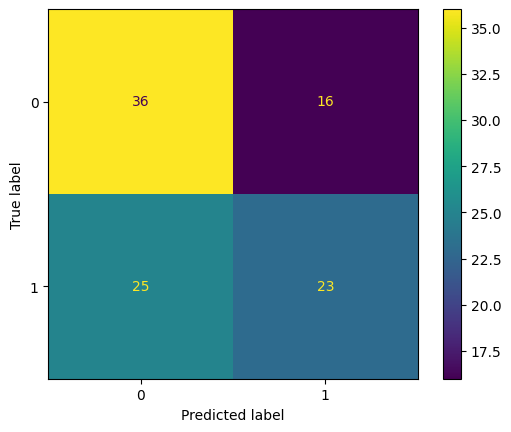

In [24]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.show()